<a href="https://colab.research.google.com/github/KT2001/Siamese-Model-for-Omniglot-Dataset/blob/main/Omniglot_Dataset_OneShotProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing necessary libraries**


In [1]:
# import necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import Tensorflow libraries
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Lambda
from tensorflow.compat.v1 import ConfigProto
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import uuid
import cv2

import scipy.ndimage as ndi
import sys
import imageio
from imageio import imread

from sklearn.utils import shuffle

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
!nvidia-smi

Wed Dec 21 12:59:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |    312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Collecting and preprocessing the data**

In [ ]:
!unzip /content/drive/MyDrive/Siamese/Omniglot/images_background.zip

In [ ]:
!unzip /content/drive/MyDrive/Siamese/Omniglot/images_evaluation.zip

In [6]:
num_classes_background = {}
sum = 0
dir = os.listdir('/content/images_background')
print(f"Number of classes: {len(dir)} \n")
for filenames in dir:
  num_classes_background[filenames] = len(os.listdir(f"{'/content/images_background'}/{filenames}"))
  sum = num_classes_background[filenames]+sum
  print(f"{filenames}: {(num_classes_background[filenames])}")
print(f"\nTotal number of images: {sum}")

Number of classes: 30 

Alphabet_of_the_Magi: 20
Korean: 40
Latin: 26
Asomtavruli_(Georgian): 40
Ojibwe_(Canadian_Aboriginal_Syllabics): 14
Mkhedruli_(Georgian): 41
Braille: 26
Inuktitut_(Canadian_Aboriginal_Syllabics): 16
Burmese_(Myanmar): 34
N_Ko: 33
Grantha: 43
Anglo-Saxon_Futhorc: 29
Gujarati: 48
Japanese_(hiragana): 52
Hebrew: 22
Futurama: 26
Sanskrit: 42
Malay_(Jawi_-_Arabic): 40
Balinese: 24
Japanese_(katakana): 47
Greek: 24
Bengali: 46
Blackfoot_(Canadian_Aboriginal_Syllabics): 14
Early_Aramaic: 22
Syriac_(Estrangelo): 23
Arcadian: 26
Tifinagh: 55
Armenian: 41
Cyrillic: 33
Tagalog: 17

Total number of images: 964


In [7]:
num_classes_evaluation = {}
sum = 0
dir = os.listdir('/content/images_evaluation')
print(f"Number of classes: {len(dir)} \n")
for filenames in dir:
  num_classes_evaluation[filenames] = len(os.listdir(f"{'/content/images_evaluation'}/{filenames}"))
  sum = num_classes_evaluation[filenames]+sum
  print(f"{filenames}: {(num_classes_evaluation[filenames])}")
print(f"\nTotal number of images: {sum}")

Number of classes: 20 

Keble: 26
Sylheti: 28
ULOG: 26
Tengwar: 25
Old_Church_Slavonic_(Cyrillic): 45
Avesta: 26
Syriac_(Serto): 23
Glagolitic: 45
Atlantean: 26
Oriya: 46
Ge_ez: 26
Manipuri: 40
Malayalam: 47
Angelic: 20
Mongolian: 30
Aurek-Besh: 26
Atemayar_Qelisayer: 26
Kannada: 41
Tibetan: 42
Gurmukhi: 45

Total number of images: 659


In [8]:
train_path = os.path.join('/content/images_background')
val_path = os.path.join('/content/images_evaluation')

In [9]:
def loading(path,n = 0, verbose = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                image = image/255
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [11]:
# loading the training set
xtrain, y_train, c_train = loading(train_path, verbose = True)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Braille
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Burmese_(Myanmar)
loading alphabet: N_Ko
loading alphabet: Grantha
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Gujarati
loading alphabet: Japanese_(hiragana)
loading alphabet: Hebrew
loading alphabet: Futurama
loading alphabet: Sanskrit
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Balinese
loading alphabet: Japanese_(katakana)
loading alphabet: Greek
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Early_Aramaic
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Arcadian
loading alphabet: Tifinagh
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Tagalog


In [12]:
# loading the validation set
xval, y_val, c_val = loading(val_path)

loading alphabet: Keble
loading alphabet: Sylheti
loading alphabet: ULOG
loading alphabet: Tengwar
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Avesta
loading alphabet: Syriac_(Serto)
loading alphabet: Glagolitic
loading alphabet: Atlantean
loading alphabet: Oriya
loading alphabet: Ge_ez
loading alphabet: Manipuri
loading alphabet: Malayalam
loading alphabet: Angelic
loading alphabet: Mongolian
loading alphabet: Aurek-Besh
loading alphabet: Atemayar_Qelisayer
loading alphabet: Kannada
loading alphabet: Tibetan
loading alphabet: Gurmukhi


In [13]:
xtrain.shape

(964, 20, 105, 105)

In [14]:
xval.shape

(659, 20, 105, 105)

In [15]:
print(list(c_train.keys()))

['Alphabet_of_the_Magi', 'Korean', 'Latin', 'Asomtavruli_(Georgian)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Mkhedruli_(Georgian)', 'Braille', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Burmese_(Myanmar)', 'N_Ko', 'Grantha', 'Anglo-Saxon_Futhorc', 'Gujarati', 'Japanese_(hiragana)', 'Hebrew', 'Futurama', 'Sanskrit', 'Malay_(Jawi_-_Arabic)', 'Balinese', 'Japanese_(katakana)', 'Greek', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Early_Aramaic', 'Syriac_(Estrangelo)', 'Arcadian', 'Tifinagh', 'Armenian', 'Cyrillic', 'Tagalog']


In [16]:
# converting data into batches
def get_batches(batch_size, data=xtrain):
  """Create batch of n pairs, half same class, half different class"""
  '''
  if data == xtrain:
    categories = c_train
  else:
    categories = c_val
  '''
  #tf.config.run_functions_eagerly(True)
  n_classes, n_examples, w, h = data.shape

   # pick the categories of characters we will return 
  categories = np.random.choice(n_classes, size=(batch_size,), replace = False)

  # initialize the data we return in memory
  pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]

  # make the target vector with half same half other category
  targets = np.zeros((batch_size,))
  targets[batch_size//2:] = 1

  for i in range(batch_size):
    category = categories[i]

    ## choose two indices from the amount of examples 
    id1 = np.random.randint(0, n_examples)
    pairs[0][i,:,:,:] = data[category, id1].reshape(w, h, 1)
    id2 = np.random.randint(0, n_examples)

    # pick images of same class for 1st half, different for 2nd
    if i >= batch_size // 2:
      category_2 = category  
    else: 
      # add a random number to the category module n classes to ensure 2nd image has a different category
      category_2 = (category + np.random.randint(1,n_classes)) % n_classes
    pairs[1][i,:,:,:] = data[category_2, id2].reshape(w, h, 1)

  return pairs, targets

In [17]:
from sklearn.utils import shuffle

For testing out the model we will build a make_oneshot_task method that would return pairs and targets with one test image that will satisfy as our correct image and rest images are going to be support set images which will be different.

In [18]:
def make_oneshot_tasks(N, data, language=None):
  """Create pairs of test image, support set for testing N way one-shot learning. """
  n_classes, n_examples, w, h = data.shape
  
  indices = np.random.randint(0, n_examples,size=(N,))
  if language is not None: # if language is specified, select characters for that language
    low, high = categories[language]
    if N > high - low:
        raise ValueError("This language ({}) has less than {} letters".format(language, N))
    categories = np.random.choice(range(low,high),size=(N,),replace=False)

  else: # if no language specified just pick a bunch of random letters
    categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
  true_category = categories[0]
  ex1, ex2 = np.random.choice(n_examples,replace=False,size=(2,))
  test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
  support_set = data[categories,indices,:,:]
  support_set[0,:,:] = data[true_category,ex2]
  support_set = support_set.reshape(N, w, h,1)
  targets = np.zeros((N,))
  targets[0] = 1
  targets, test_image, support_set = shuffle(targets, test_image, support_set)
  pairs = [test_image,support_set]

  return pairs, targets

In [20]:
pairs, targets = make_oneshot_tasks(N = 20, data = xval)

In [22]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img, n

In [23]:
def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.set_facecolor('white')
    ax1.set_title("Test Image")
    ax2.set_title("Support Set")
    ax2.grid(linewidth=1,linestyle='-',color='black')
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img,n = concat_images(pairs[1])
    ax2.matshow(img,cmap='gray')
    plt.xticks(np.arange(0,105*n,105))
    plt.yticks(np.arange(0,105*n,105))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    plt.show()

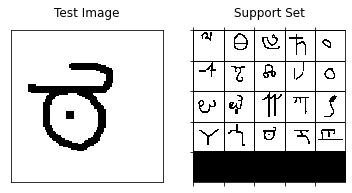

In [24]:
plot_oneshot_task(pairs)

A method to test the validity of our model against N way one shot learning

In [19]:
def test_oneshots(model, N, k, s = xval, verbose = 0):
  """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
  n_correct = 0
  if verbose:
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
  for i in range(k):
    inputs, targets = make_oneshot_tasks(N,s)
    probs = model.predict(inputs)
    if np.argmax(probs) == np.argmax(targets):
      n_correct = n_correct+1
  percent_correct = (100.0 * n_correct / k)
  if verbose:
    print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
  return percent_correct

###**Model Building**

These are the weights and biases as mentioned in the orignal paper https://paperswithcode.com/paper/siamese-neural-networks-for-one-shot-image

In [25]:
def W_init(shape, dtype=None):
  """Initialize weights as in paper"""
  values = np.random.normal(loc=0,scale=1e-2,size=shape)
  return K.variable(values, dtype=dtype)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape, dtype=None):
  """Initialize bias as in paper"""
  values=np.random.normal(loc=0.5,scale=1e-2,size=shape)
  return K.variable(values, dtype=dtype)

In [27]:
# Siamese Model
input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
convnet = models.Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_network = models.Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_network.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_network.count_params()

38951745

In [28]:
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 4096)         38947648    ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [29]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 30000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = []

In [30]:
model_path = '/content/drive/MyDrive/Siamese/Weights/Weights_1'

In [31]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs,targets = get_batches(batch_size)
    loss = siamese_network.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshots(siamese_network, N_way, n_val, verbose=True)
        #siamese_net.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        '''
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc
        '''
        best.append(val_acc)
        print(f"Current best:{val_acc}")
siamese_network.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
Got an average of 67.6% 20 way one-shot learning accuracy 

Current best:67.6

 ------------- 

Time for 12000 iterations: 21.84327027797699 mins
Train Loss: 0.22138971090316772
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 18ms/step
Got an average of 66.0% 20 way one-shot learning accuracy 

Current best:66.0

 ------------- 

Time for 13000 iterations: 23.688528915246327 mins
Train Loss: 0.19093623757362366
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 25ms/step
Got an average of 68.0% 20 way one-shot learning accuracy 

Current best:68.0

 ------------- 

Time for 14000 iterations: 25.515534484386443 mins
Train Loss: 0.16762469708919525
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 18ms/step
G

The model gave **Train Loss** of 0.14 or 14% and the final **validation accurracy** on 30k runs is 75.6%.

In [32]:
best

[25.6,
 40.0,
 41.6,
 56.0,
 56.0,
 57.6,
 64.8,
 60.4,
 71.6,
 70.4,
 67.6,
 66.0,
 68.0,
 73.2,
 72.0,
 70.8,
 74.4,
 71.6,
 75.2,
 75.2,
 75.2,
 68.8,
 70.0,
 67.2,
 72.0,
 76.4,
 72.0,
 80.0,
 71.2,
 75.6]

### **Comparing against k nearest neighbour algorithm**

In [35]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [36]:
def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials